In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
import numpy as np
import seaborn as sns
sns.set()

In [2]:
ls

BCRTESTDFfeatures.csv
BCRdataCDRpept_nonpept.csv
BCRdataCDRpeptnonpept_LPS.csv
BCRdataCDRpeptnonpept_LPS_enriched.csv
HUMANBCRdataCDRpept_nonpept.csv
HUMANBCRdataCDRpeptnonpept_LPS_enriched.csv
KABABCRdataCDRpeptnonpept_LPS_enrichedfeatures.csv
KABATBCRdataCDRpeptnonpept_LPS_enriched.csv
KABATBCRdataCDRpeptnonpept_PNEUMO.csv
RFCDR3peptnonpept_LPS_enriched.joblib
TESTBCRdataCDRpeptnonpept_LPS_enriched.csv
__pycache__/
data/
data_labeling.ipynb
df_functions.py
epitope_labels.pdf
featurematrix.ipynb
featurespept_nonpept.csv
featurespeptnonpept_LPS.csv
featurespeptnonpept_LPS_enriched.csv
figdir/
get_data_IEDB.ipynb
nonLPS_peptide.csv
nonLPSfeautrues.csv
non_peptide_clf.ipynb
non_peptides.csv
organism_dict.json
profile_distances.py


DATA IS ALL ORGANISMS, B CELL RESPONSE

In [3]:
s = 'KABAT_human_mouseBCRHCDR3.csv'
s[20:25]

'HCDR3'

In [4]:
#files generated in notebook 'get_data_IEDB.pynb'
#create one database with new column for region (complementary determining region)

#files = ['BCRHCDR3.csv','BCRHCDR2.csv','BCRHCDR1.csv','BCRLCDR3.csv','BCRLCDR2.csv','BCRLCDR1.csv']
files = ['KABAT_human_mouseBCRHCDR3.csv','KABAT_human_mouseBCRHCDR2.csv','KABAT_human_mouseBCRHCDR1.csv','KABAT_human_mouseBCRLCDR3.csv','KABAT_human_mouseBCRLCDR2.csv','KABAT_human_mouseBCRLCDR1.csv']
datadir = Path('data')
dfs = []
regions = []
for file in files:
    df = pd.read_csv(datadir / file, dtype='object', skip_blank_lines=True, skipinitialspace=True )
    df = df.apply(lambda x: x.str.strip())
    region = str(file[20:25])
    regions.append(region)
    df['region'] = region
    df.rename(columns={region: 'sequence'}, inplace= True)

    df = df.filter(['sequence', 'Epitope', 'Antigen', 'region'])

    df.dropna(subset = ['Epitope', 'sequence'], inplace=True)
    df.drop_duplicates(subset= ['Epitope', 'sequence'], inplace=True)

    dfs.append(df)
    
    print(region, 'shape:', df.shape)


df = pd.concat(dfs, ignore_index=True, axis=0, sort=False)

HCDR3 shape: (2088, 4)
HCDR2 shape: (1786, 4)
HCDR1 shape: (1764, 4)
LCDR3 shape: (1794, 4)
LCDR2 shape: (1709, 4)
LCDR1 shape: (1737, 4)


In order to determine what kind of epitopes are in the database, we have to categorize them ourselves. This is based on the way the epitopes are represented as strings. For example, strictly linear epitopes only have capital alphabetic characters, whereas a PTM is introduced with a '+' and '()'' signs. Discontinuous epitope are represented along with their (numeric) number from the antigenic peptide chain. (Possibly, you can also merge the 'bcell_full_v3.csv' to accomplish this)

Here are examples of peptide notations:

    - Linear: NWFDITNWLWYIK
    - Linear with PTM: ARTKQTARKSTG + METH(K4)
    - Discontinuous : K42, F43, M44, D45, Y47, Q48, R49, Y51, K127, C130
    - Discontinuous with PTM: H129, N166, D173, K174, K175, K177 + GLYC(N162, N166)
    - Multichain: A: S63, S64, D65, Y66, R69; B: L97, Y108, H109, M110, N111, P149, I150
    - Multichain with PTM: HA1: E341; HA2: E360, G361, I363, D364, R370, E375, T377, G378, Q379, A380, A381, L383, N491, E495 + GLYC(2:N499) 
    - Different (old) notation: Ac-Gln-D-Phe-His-D-Pro-NH2

Here are examples of other structures:
    - cardiolipin
    - 1,2-dihexanoyl-sn-glycero-3-phosphate
    - testosterone
 
A large fraction of the non_peptides appear to be lipopolysacharides, glycoproteins. These have long carbohydrate chains.

In [5]:
#because lipopolysaccharide_own has 100+ 'epitopes'
for region, frame in zip(regions,dfs):
    print(len(frame['Epitope'].unique()), region)

1665 HCDR3
1606 HCDR2
1606 HCDR1
1612 LCDR3
1585 LCDR2
1585 LCDR1


In [6]:
# The entries in the db that are true labeled as lipopolyssaccharide. 
true_LPS = np.unique(df[df['Antigen'] == 'lipopolysaccharide']['Epitope'])

In [7]:
#Enrichment with lipopolysaccharides from own database
#Drop these in the first run of the classifier when only checking peptide vs non peptide from IEDB
#Although it would make sense adding them in the first run also as they are non peptides.
print(len(df[df['Epitope'] == 'lipopolysaccharide_own']))

#indexNames_owndb = df[df['Epitope']=='lipopolysaccharide_own'].index
#print(df.shape)
#df.drop(indexNames_owndb, axis=0, inplace=True)
#print(df.shape)

111


In [8]:
#TOTAL NUMBER OF EPITOPES
total_epitopes = len(df['Epitope'].unique())
print("Total epitopes:", len(df['Epitope'].unique()))

#NON PEPTIDIC EPITOPES
not_peptidelower = [epitope for epitope in df['Epitope'] if epitope.islower()]  #no peptides in here
not_peptidedigit = [epitope for epitope in df['Epitope'] if epitope[0].isdigit()] #no peptides in here
not_peptidehyphen = [epitope for epitope in df['Epitope'] if ('-') in epitope] #Has peptides

#PEPTIDIC EPITOPES
peptides_diffnotation = [x for x in not_peptidehyphen if x.startswith('Ac')]
[not_peptidehyphen.remove(x) for x in peptides_diffnotation]

strictly_linear = [epitope for epitope in df['Epitope'] if epitope.isalpha() and epitope.isupper()]
strictly_linear.extend(peptides_diffnotation)

linear_PTM = [epitope for epitope in df['Epitope'] if epitope.split()[0].isalpha() and epitope.endswith(')')]

discontinuous = [epitope for epitope in df['Epitope'] if epitope.isupper() and (',') in epitope and not epitope.endswith(')')]

multichain_epitopes = [x for x in discontinuous if ':' in x]
chain_epitopes = [x for x in df['Epitope'] if x.startswith('Chain')]
multichain_epitopes.extend(chain_epitopes)

true_discontinuous = [x for x in discontinuous if x not in multichain_epitopes]

discontinuous_PTM = [epitope for epitope in df['Epitope'] if (',') in epitope and epitope.endswith(')')  and epitope not in linear_PTM]

multichain_PTM = [x for x in discontinuous_PTM if ':' in x]

#LPS (these are already in non_peptides, but make seperate lists to put in dict)
#LPS_tags = ['rhamno', 'Rha', 'Kdo', 'Neu5Ac', 'GlcpNAc', 'GlcNAc', 'Galp', 'Fucp', 'Man', 
#            'manno','Neu5Pr','lipopolysaccharide', 'Ko', 'Neu5NAc',
#            'GalNAcAN', 'Araf', 'NeuNAc', 'fucopyranosyl', 'GlcN4P','lipopolysaccharide_own']
LPS_tags = 'lipopolysaccharide_own'

LPS = [epi for epi in df['Epitope'] if any(string in epi for string in LPS_tags)]

left_over_multi = ['A: N24, G26, P27, V29, T155, K156, E159, L161, Y190, T192, S193, V194, T195, N196, I199; B: Q169, L170, K171, V172 \tDiscontinuous protein',
                   'a: R356, C360, L387, S389, N390, N395, E396, T397, H398, F399, S400, D401, D402, E404, Q405, D408; b: S269, E270, G271, K272, D273, T274, P275, Q324, R325, K327'
                  ]
multichain_epitopes.extend(left_over_multi)
    
#Lists to store epitopes

peptides = []
peptides_PTM = []
non_peptides = []

peptides.extend(strictly_linear)
peptides.extend(multichain_epitopes)
peptides.extend(true_discontinuous)
peptides.extend(peptides_diffnotation)
print('Number of peptides:',len(set(peptides)))

peptides_PTM.extend(linear_PTM)
peptides_PTM.extend(discontinuous_PTM)
peptides_PTM.extend(multichain_PTM)
print('Number of Peptides with PTM:',len(set(peptides_PTM)))
peptides.extend(peptides_PTM)
      
non_peptides.extend(not_peptidelower)
non_peptides.extend(not_peptidedigit)
non_peptides.extend(not_peptidehyphen)
non_peptides.extend(LPS)

left_over_nonpept = ['Reactive Red 6 hapten copper complex',
                     'estriol 3-O-(beta-D-glucuronide)',
                     'estrone 3-O-(beta-D-glucuronide)',
                     'gibberellin A4',
                     'cyclosporin A',
                     'leukotriene C4'
                    ]
non_peptides.extend(left_over_nonpept)

non_peptides=[x for x in non_peptides if x not in peptides_PTM]
non_peptides=[x for x in non_peptides if x not in multichain_epitopes]
non_peptideslipo = [x for x in non_peptides if x not in LPS]

peptides_PTM = [x for x in peptides_PTM if x not in non_peptides]

print('Number of non peptides:',len(set(non_peptides)))

Total epitopes: 1669
Number of peptides: 1305
Number of Peptides with PTM: 60
Number of non peptides: 297


In [9]:
#The substrings in the true labeled LPS can be found in other structures that are LPS or derivatives, 
#but are not labeled as such in the database
substrings = []
for x in [x.split('-') for x in true_LPS]:
    substrings.extend(x)

#Counter(substrings).most_common()
alpha = [x for x in df['Epitope'] if 'alpha' in x]
#set([x for x in alpha if x not in LPS])
print('Unique LPS epitopes:',len(LPS))

Unique LPS epitopes: 2474


In [10]:
#Dict to store epitopes and label
label_dict = {}
label_dict['non_peptides'] = set(non_peptideslipo)
label_dict['peptides'] = set(peptides)
label_dict['strictly_linear'] = set(strictly_linear)
label_dict['true_discontinuous'] = set(true_discontinuous)
label_dict['lipopolysaccharides'] = set(LPS)
label_dict['multichain_epitopes'] = set(multichain_epitopes)
label_dict['peptides_PTM'] = set(peptides_PTM)

#Leave the groups you don't want in the final labeling out of the sorted epitopes
#For example don't include PTM peptides when comparing non_peptide vs peptide
#sorted_epitopes = set(LPS + peptides + non_peptideslipo)
sorted_epitopes = set(peptides + non_peptideslipo+LPS)
print('Number of sorted epitopes:', len(set(sorted_epitopes)))

len(set(sorted_epitopes)), len(set(peptides)), len(set(non_peptides)),len(set(peptides_PTM)), len(set(LPS)), len(set(multichain_epitopes))

Number of sorted epitopes: 1650


(1650, 1365, 297, 60, 306, 139)

In [11]:
len(label_dict['lipopolysaccharides'])

306

In [12]:
#Check duplicates/overlap between groups

keys = list(label_dict.keys())
del_keys = []
for key in keys:
    del_keys.append(key)
    keys = [x for x in keys if x not in del_keys]
    if len(keys) ==1:
        break
    for new_key in keys:
        duplicates = [x for x in label_dict[key] if x in label_dict[new_key]]
        print(f'Epitopes shared between {key} and {new_key}:', len(duplicates), len(label_dict[key]), len(label_dict[new_key]))
        print('\n', duplicates, '\n')
        
#unsorted epitopes
unsorted = [x for x in df['Epitope'].unique() if x not in set(sorted_epitopes)]
#mannually add to category

#left over seem fishy and unclear. Could be epitopes of one AA or abreviations (E404f ood additive?). Look up if time.
#Some might refer to point mutations in specific proteins (check 'Antigen column')
#Some can be sorted though and are added on above to their group
left_over = [x for x in unsorted if x not in peptides_PTM]

Epitopes shared between non_peptides and peptides: 0 8 1365

 [] 

Epitopes shared between non_peptides and strictly_linear: 0 8 372

 [] 

Epitopes shared between non_peptides and true_discontinuous: 0 8 794

 [] 

Epitopes shared between non_peptides and lipopolysaccharides: 0 8 306

 [] 

Epitopes shared between non_peptides and multichain_epitopes: 0 8 139

 [] 

Epitopes shared between non_peptides and peptides_PTM: 0 8 60

 [] 

Epitopes shared between peptides and strictly_linear: 372 1365 372

 ['GKLGLITNTIAGVAGLI', 'TGHRMAWDMMM', 'GPCKTCT', 'EEKKGNYVVTDH', 'PRGYPGQV', 'GLYEWGGARITNTD', 'DAEFRH', 'RRPSHQQPRKIRPEGREGEQEWGT', 'MATLEKLMKAFESLKSF', 'SAPDTRPAP', 'PRREEGGRWGPAEPREREREEDWR', 'PPYPAWHAPGNI', 'NQNNFVHDCVNITIKQHTVT', 'RKRIRVGPGQTVY', 'DTVTVEDLKQRGISAERPLVYISS', 'ISFPEGFPFKY', 'HIGPGRAFYT', 'Ac-D-His-Pro-NH2', 'LRDKKQKVHALFYKADAV', 'GACRNPWGLTCGAAGAEK', 'KGVRIGPGQA', 'KPNDAINF', 'SYWQKSPTG', 'Ac-Gln-D-Phe-His-D-Pro', 'ILPWKWPWWPWRR', 'DFHFEVFNF', 'Ac-D-Phe-betaAla-L-His-D

It's quiet difficult tot exactly filter out chemical structures that are non peptidic. In a way you can't really define a structure different to peptide. Although, a peptide is made up of amino acid monomers linked through the peptidic bond. As all peptides share this bond, it is not expected to have a strong influence on peptidic epitope specificity. Not to forget, the BCR is ofcourse also peptidic. The functional groups of the amino acids however, and their spatial organisation along the peptide would contribute more to specificity for both CDRH3  and the peptidic epitope. 
Non-proteinogenic amino acids are very similar to the proteinogenic amino acids. 



In [13]:
unsorted

['R204',
 'P176',
 'S98',
 'R214',
 'R19',
 'K163',
 'D158',
 'S203',
 'G528',
 'N669',
 'S806',
 'Y671',
 'D729',
 'T797',
 'D675',
 'T210',
 'N847',
 'E404',
 'K218',
 'E129',
 'I390']

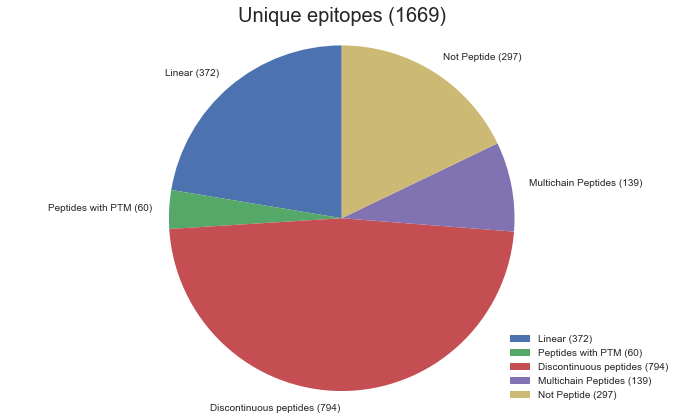

In [14]:
#Pie Chart 2: Number of epitopes with at least one CDR entry in the IEDB database. 
#Some epitopes have multiple entries with different CDR sequences

epitope_type_counts = [len(set(strictly_linear)), len(set(peptides_PTM)), len(set(true_discontinuous)),#len(set(lipopolysaccharides)),
                       len(set(multichain_epitopes)), len(set(non_peptides))]

epitope_type = [f'Linear ({len(set(strictly_linear))})', 
                f'Peptides with PTM ({len(set(peptides_PTM))})', 
                f'Discontinuous peptides ({len(set(true_discontinuous))})', 
                #f'lipopolysaccharides ({len(set(lipopolysaccharides))})', 
                f'Multichain Peptides ({len(set(multichain_epitopes))})', 
                f'Not Peptide ({len(set(non_peptides))})']

fig, ax = plt.subplots(figsize=(12,7))
ax.pie(epitope_type_counts, labels = epitope_type, startangle=90)
ax.axis('equal')
ax.set_title(f"Unique epitopes ({len(df['Epitope'].unique())})", fontsize= 20)
plt.legend(loc = 4)
plt.savefig('epitope_labels.pdf')
plt.show()

In [15]:
#Add label for classifier (Find better way to do this)
peptide_label = []
for x in df['Epitope']:
    if x in label_dict['peptides'] or x in label_dict['non_peptides']:
            peptide_label.append('0')
    else:
        if x in label_dict['lipopolysaccharides']:
            peptide_label.append('1')
        else:
            if x in unsorted:
                peptide_label.append(np.nan)

print(len(peptide_label), len(df['Epitope']))
Counter(peptide_label)

10878 10878


Counter({'0': 8448, '1': 2300, nan: 130})

In [16]:
len(df['Epitope']), len(peptide_label), list(df)

(10878, 10878, ['sequence', 'Epitope', 'Antigen', 'region'])

In [17]:
df.loc[df['Epitope'] == 'lipopolysaccharide_own', 'sequence'] = df.loc[df['Epitope'] == 'lipopolysaccharide_own', :]['sequence'].apply(lambda x: x[1:-1])

In [18]:
df.dropna(subset =('sequence', 'Epitope', 'region'),inplace=True)

In [19]:
len(df['Epitope']), len(peptide_label)

(10878, 10878)

In [20]:
df['peptide_label'] = peptide_label
df['peptide_label'].value_counts()

0    8448
1    2300
Name: peptide_label, dtype: int64

In [21]:
#df[df['peptide_label']=='1'].to_csv('non_peptides.csv')

In [22]:
#Create csv with columns for featurematrix i.e CDR and Label must remain
print('Original shape:', df.shape)
#Drop columns wich we don't need
df.drop(labels = ['Epitope', 'Antigen'], axis = 'columns', inplace=True)
print('Drop columns:', df.shape)

#Drop na values along the peptide_label column
df.dropna(subset=['peptide_label'], inplace=True)
print('Dropped label NA:', df.shape)

#Of the columns that remain; CDR and peptide label region, drop duplicates
print('Names columns:', list(df))
df.drop_duplicates(inplace=True)
print('Dropped duplicates :', df.shape)

Original shape: (10878, 5)
Drop columns: (10878, 3)
Dropped label NA: (10748, 3)
Names columns: ['sequence', 'region', 'peptide_label']
Dropped duplicates : (4841, 3)


In [23]:
df['region'].value_counts()

HCDR3    1283
LCDR3     951
HCDR2     893
HCDR1     764
LCDR1     683
LCDR2     267
Name: region, dtype: int64

In [24]:
#export with peptide and non_peptides
#df.to_csv('BCRdataCDRpept_LPS.csv', index=False)
#df.to_csv('BCRdataCDRpeptnonpept_LPS.csv', index=False)
#df.to_csv('BCRdataCDRpeptnonpept_LPS_enriched.csv', index=False)
#df.to_csv('BCRdataCDRpept_nonpept.csv', index=False)
df.to_csv('pneumotestje.csv', index=False)